<a href="https://colab.research.google.com/github/andreiamferreira/cyst-ultrasound-cnn/blob/main/cyst_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [415]:
import os
import cv2
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn.metrics as skm
import matplotlib.pyplot as plt

from tqdm import tqdm
from random import randint
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

import warnings
warnings.simplefilter("ignore")

In [416]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Interface de leitura dos dados**

Classes de neurofibroma, mestase, SK, AK, e angioma eram muito pequenas, então fiz a rotação manual de 90º para a direita, e adicionei as imagens à pasta do drive. Para conseguir adicionar as labels, alterei o csv para incluir essas novas imagens na listagem, e por isso foi necessária a normalização.

In [417]:
image_size = 150  # Tamanho para redimensionar as imagens

folder_path = "/content/gdrive/MyDrive/Diagnostico/trabalho/dataset/bw"

# Como eu alterei o csv original para adicionar as imagens rotacionadas manualmente, tive que re-normalizar o csv
data = pd.read_csv("/content/gdrive/MyDrive/Diagnostico/trabalho/dataset/201databaseaugmented.csv - 201database.csv", delimiter=",", quotechar='"')

if 'images_bw, image_doppler, label, dx, freq' in data.columns:
    data_split = data['images_bw, image_doppler, label, dx, freq'].str.split(',', expand=True)
    data_split.columns = ['images_bw', 'image_doppler', 'label', 'dx', 'freq']
else:
    data_split = data

data_split['images_bw'] = data_split['images_bw'].str.strip()
data_split['dx'] = data_split['dx'].str.strip()


In [418]:
images = []
labels = []
filenames = []

# Processando imagens e labels
for index, row in tqdm(data_split.iterrows(), total=len(data_split)):
    image_path = os.path.join(folder_path, os.path.basename(row['images_bw']))
    image = cv2.imread(image_path)

    if image is not None:
        image = cv2.resize(image, (image_size, image_size))
        images.append(image)
        labels.append(row['dx'])                                          # coluna 'label' contem maligno/benigno, é a 'dx' que possui o diagnostico
        filenames.append(os.path.basename(row['images_bw']))
    else:
        print(f"Erro na imagem: {image_path}")

images = np.array(images)
labels = np.array(labels)
filenames = np.array(filenames)

print("Quantidade de imagens processadas no dataset: ", len(images))        # não utilizei as imagens com doppler, por isso apenas 224 imagens
print("Dimensões das imagens: ", images.shape)
print("Cinco primeiras labels: ", labels[:5])

100%|██████████| 224/224 [00:01<00:00, 119.75it/s]

Quantidade de imagens processadas no dataset:  224
Dimensões das imagens:  (224, 150, 150, 3)
Cinco primeiras labels:  ['VENOUS MALFORMATION' 'LEIOMIOMA' 'ANGIOMA' 'SCHWANOMA' 'LEIOMIOMA']


Validando para ver se as imagens foram carregadas corretamente, e se a classificação e caminho de arquivo de cada imagem está correta.

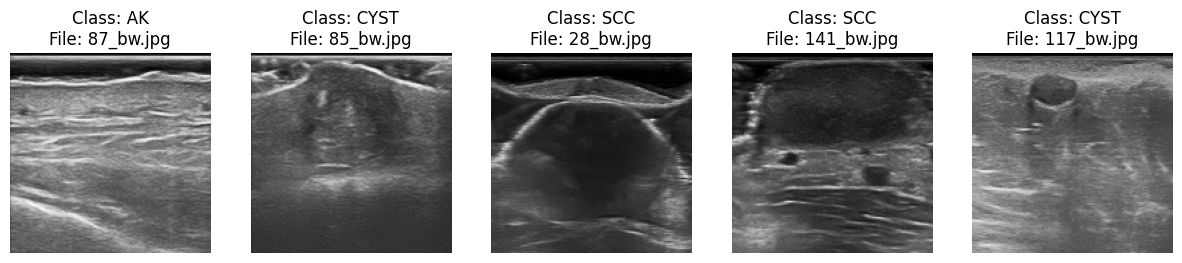

In [464]:
# Função para mostrar as imagens com as labels e com o nome do arquivo, para verificação no csv
# Mantive em formato de função para ser reutilizada posteriormente
plt.figure(figsize=(15, 5))
num_images=5                                          # mostra 5 imagens

for i in range(num_images):
  idx = random.randint(0, len(images) - 1)            # escolhe um índice aleatória sempre que roda
  img = images[idx]
  label = labels[idx]
  filename = filenames[idx]

  plt.subplot(1, num_images, i + 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title(f"Class: {label}\nFile: {filename}")
  plt.axis('off')
plt.show()

Separação dos conjuntos de treino e teste de acordo com as classes escolhidas.

Plotagem de imagens + classe + nome do arquivo, para verificação.

Imagens por classe no conjunto de treino:
{'BCC': 31, 'SCC': 11, 'CYST': 38, 'AK': 10, 'DERMATOFIBROMA': 17, 'LIPOMA': 24, 'METASTASIS': 7, 'SEBORRHEIC KERATOSIS': 8, 'ANGIOMA': 5, 'NEUROFIBROMA': 5}
Quantidade total:  156
Imagens por classe no conjunto de teste:
{'BCC': 8, 'SCC': 3, 'CYST': 10, 'AK': 2, 'DERMATOFIBROMA': 5, 'LIPOMA': 6, 'METASTASIS': 2, 'SEBORRHEIC KERATOSIS': 2, 'ANGIOMA': 1, 'NEUROFIBROMA': 1}
Quantidade total:  40


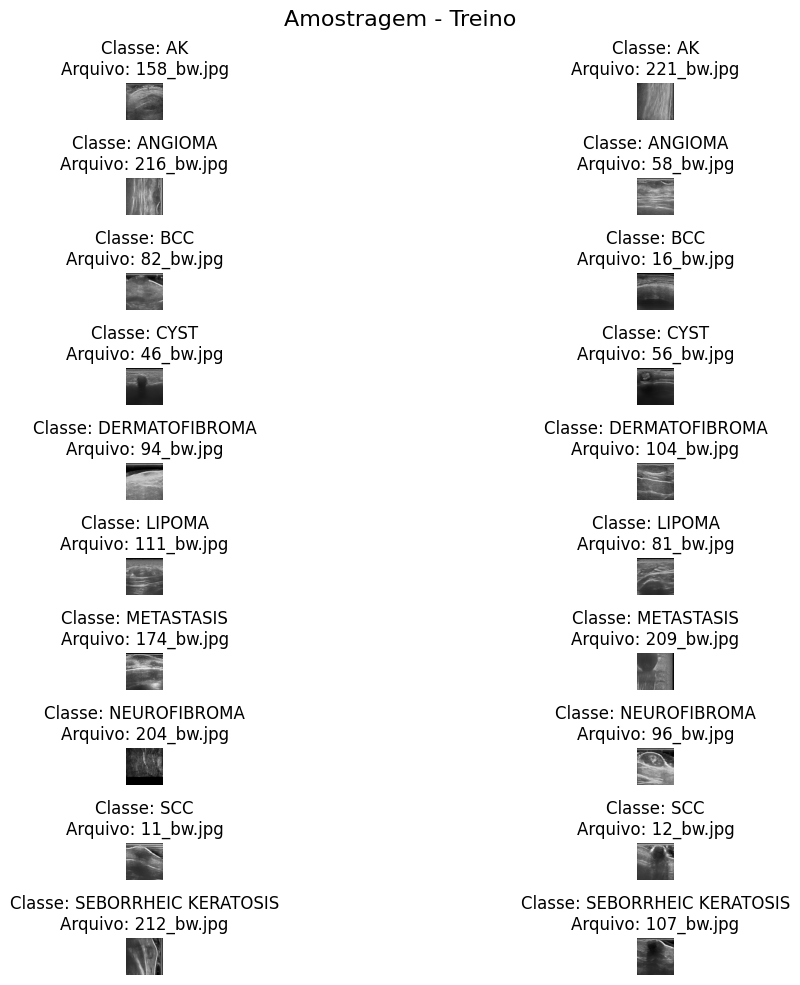

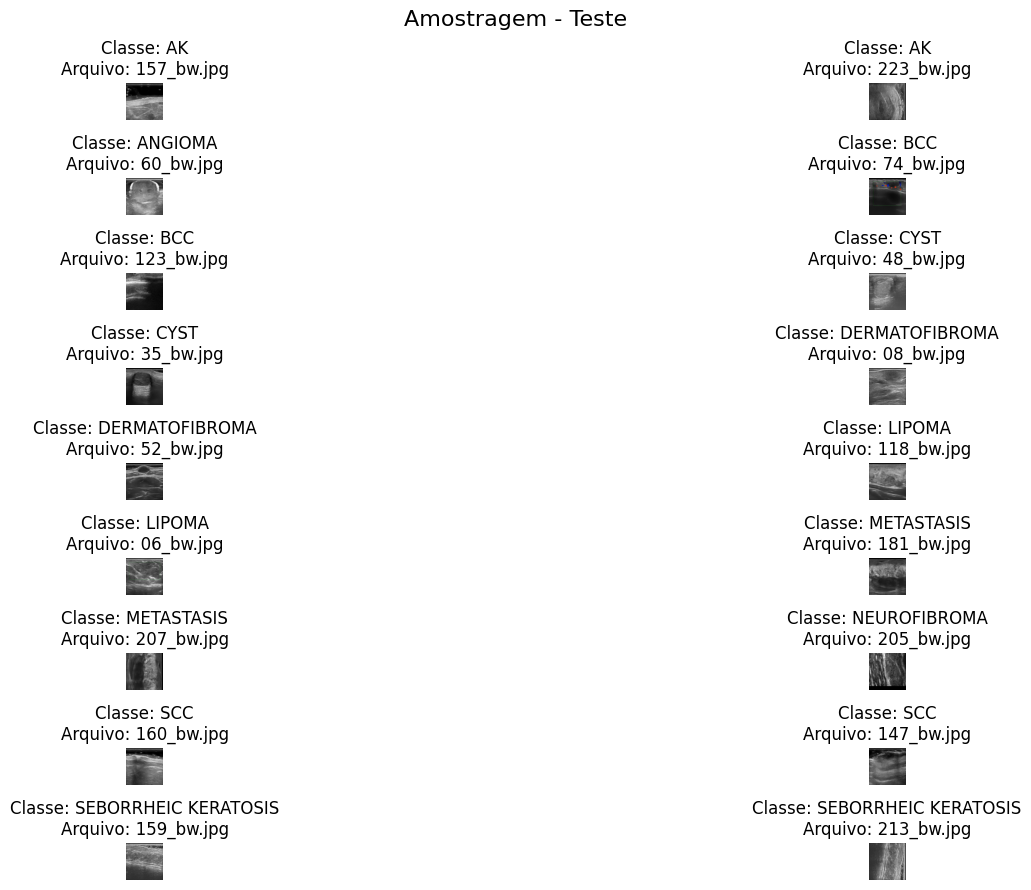

In [420]:
class_names = ['BCC', 'SCC', 'CYST', 'AK', 'DERMATOFIBROMA', 'LIPOMA',
               'METASTASIS', 'SEBORRHEIC KERATOSIS', 'ANGIOMA', 'NEUROFIBROMA']

images_of_selected_classes = []
labels_of_selected_classes = []
filenames_of_selected_classes = []

for i in range(len(labels)):
    if labels[i] in class_names:
        images_of_selected_classes.append(images[i])
        labels_of_selected_classes.append(labels[i])
        filenames_of_selected_classes.append(filenames[i])

images_of_selected_classes = np.array(images_of_selected_classes)
labels_of_selected_classes = np.array(labels_of_selected_classes)
filenames_of_selected_classes = np.array(filenames_of_selected_classes)

# normalização
images_of_selected_classes = images_of_selected_classes / 255.0

# 80/20
# lembrando que x = imagem, e y= label
x_training, x_test, y_training, y_test, filenames_training, filenames_test = train_test_split(
    images_of_selected_classes, labels_of_selected_classes, filenames_of_selected_classes, test_size=0.2, random_state=42, stratify=labels_of_selected_classes
)

# exibe imagens com labels e nomes de arquivos
def plot_images_with_labels_and_filenames(images, labels, filenames, title, num_images_per_class=0):
    unique_classes = np.unique(labels)
    plt.figure(figsize=(15, len(unique_classes) * num_images_per_class // 2))
    total_plots = len(unique_classes) * num_images_per_class
    current_plot = 1

    for class_name in unique_classes:
        class_indices = np.where(labels == class_name)[0]
        if len(class_indices) > 0:
            # Seleciona índices aleatórios da classe
            selected_indices = random.sample(list(class_indices), min(num_images_per_class, len(class_indices)))
            for index_label in selected_indices:
                plt.subplot(len(unique_classes), num_images_per_class, current_plot)
                plt.imshow(images[index_label])
                plt.title(f"Classe: {class_name}\nArquivo: {filenames[index_label]}")
                plt.axis('off')
                current_plot += 1
    plt.suptitle(f"Amostragem - {title}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Verificando se foi separado corretamente entre treino e teste

print("Imagens por classe no conjunto de treino:")
print({class_name: np.sum(y_training == class_name) for class_name in class_names})
print("Quantidade total: ", x_training.shape[0])


print("Imagens por classe no conjunto de teste:")
print({class_name: np.sum(y_test == class_name) for class_name in class_names})
print("Quantidade total: ", x_test.shape[0])

# Plotando amostras de treino e teste
plot_images_with_labels_and_filenames(x_training, y_training, filenames_training, title="Treino", num_images_per_class=2)
plot_images_with_labels_and_filenames(x_test, y_test, filenames_test, title="Teste", num_images_per_class=2)


Como será uma classificação binária, foi necessário redefinir as labels/classes para binario: tudo o que é CYST equivale a 1, e o resto equivale a 0.

In [473]:
# label binaria
binary_labels = np.array([1 if label == 'CYST' else 0 for label in labels_of_selected_classes])

x_training_validation, x_test, y_training_validation, y_test = train_test_split(
    images_of_selected_classes, binary_labels, test_size=0.2, random_state=42, stratify=binary_labels
)

x_training, x_validation, y_training, y_validation = train_test_split(
    x_training_validation, y_training_validation, test_size=0.3, random_state=42, stratify=y_training_validation
)

# verifica os conjuntos
print(f"Tamanho do conjunto de treino: {x_training.shape[0]} imagens")
print(f"Tamanho do conjunto de validação: {x_validation.shape[0]} imagens")
print(f"Tamanho do conjunto de teste: {x_test.shape[0]} imagens")


Tamanho do conjunto de treino: 109 imagens
Tamanho do conjunto de validação: 47 imagens
Tamanho do conjunto de teste: 40 imagens


**CONSTRUÇÃO DO MODELO**

A arquitetura base foi a arquitetura da CNN LeNet, uma rede simples. Ela é formada por 7 camadas:

input layer, com tamanho 32x32

C1 (convolutional layer), 5x5, produzindo feature maps de 28x28 (6 feature maps)

S2 (subsampling layer), 14x14, 6 feature maps

C3 (convolutional layer), 5x5, com 16 feature maps

S4 (subsampling layer), 7x7, 16 feature maps

C5, 120 feature maps

F6 (fully conected)

output geralmente utiliza uma função de ativação gausiana


Entretanto, como a amostra do modelo atual é pequena (224 imagens), fiz algumas modificações, como a adição de dropout para melhorar o problema de overfitting, uso de sigmoid na saida (por ser categorização binaria), e utilização da relu.

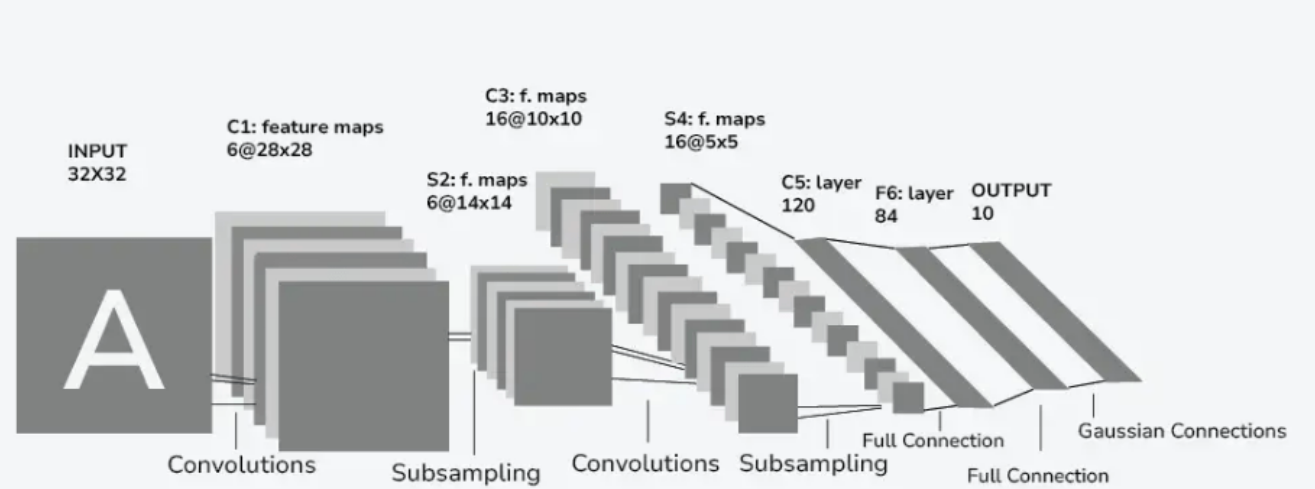

In [469]:
# fixando seeds
np.random.seed(10)
tf.random.set_seed(10)

model = Sequential([
     # C1
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),  # S2

    # C3
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),  # S4

    #
    Flatten(),
    Dense(120, activation='relu', kernel_regularizer=l2(0.001)),  # C5
    Dropout(0,3),
    Dense(84, activation='relu', kernel_regularizer=l2(0.001)),   # F6
    Dropout(0,3),

    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))  # Camada de saída para classificação binária
])

model.compile(
              optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_176 (Conv2D)                  │ (None, 146, 146, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_155 (MaxPooling2D)     │ (None, 73, 73, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_177 (Conv2D)                  │ (None, 69, 69, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_156 (MaxPooling2D)     │ (None, 34, 34, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_92 (Flatten)                 │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_272 (Dense)                    │ (None, 120)                 │       2,219,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_151 (Dropout)                │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_273 (Dense)                    │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_152 (Dropout)                │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_274 (Dense)                    │ (None, 1)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,232,761 (8.52 MB)

 Trainable params: 2,232,761 (8.52 MB)

 Non-trainable params: 0 (0.00 B)

Com a amostragem pequena, fiz uso de data augmentation para melhorar o treinamento.

In [470]:
datagen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(x_training, y_training, batch_size=15)

history = model.fit(
    train_generator,
    validation_data=(x_validation, y_validation),
    epochs=15,
    batch_size=15
)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.6973 - loss: 0.9645 - val_accuracy: 0.7660 - val_loss: 0.7853
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.7135 - loss: 0.8261 - val_accuracy: 0.7660 - val_loss: 0.7477
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.7612 - loss: 0.7392 - val_accuracy: 0.7660 - val_loss: 0.7142
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.7489 - loss: 0.7110 - val_accuracy: 0.7660 - val_loss: 0.7074
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 297ms/step - accuracy: 0.7274 - loss: 0.6972 - val_accuracy: 0.7660 - val_loss: 0.6753
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.7720 - loss: 0.6701 - val_accuracy: 0.7660 - val_loss: 0.6594
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.7729 - loss: 0.6263 - val_accuracy: 0.7660 - val_loss: 0.6446
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.7342 - loss: 0.6523 - val_accuracy: 0.7660 - val_loss:

**MÉTRICAS**

In [447]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7500 - loss: 0.5479 
Acurácia no conjunto de teste: 75.00%


Loss e Acurácia

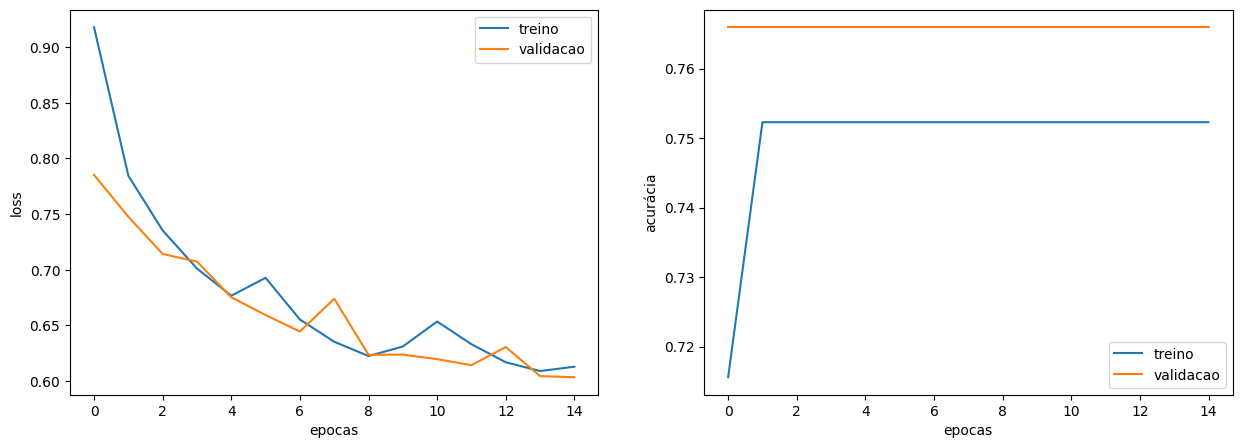

In [472]:
# plotagem dos gráficos de loss e acuracia

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="treino")
plt.plot(history.history["val_loss"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("loss")
plt.legend();
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="treino")
plt.plot(history.history["val_accuracy"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("acurácia")
plt.legend();

Matriz de Confusão e Precisão

In [475]:
predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

predicted_classes.shape, y_test.shape

target_names = ["Class {}".format(i) for i in range(2)]

print(classification_report(y_test, predicted_classes, target_names=target_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
              precision    recall  f1-score   support

     Class 0       0.75      1.00      0.86        30
     Class 1       0.00      0.00      0.00        10

    accuracy                           0.75        40
   macro avg       0.38      0.50      0.43        40
weighted avg       0.56      0.75      0.64        40



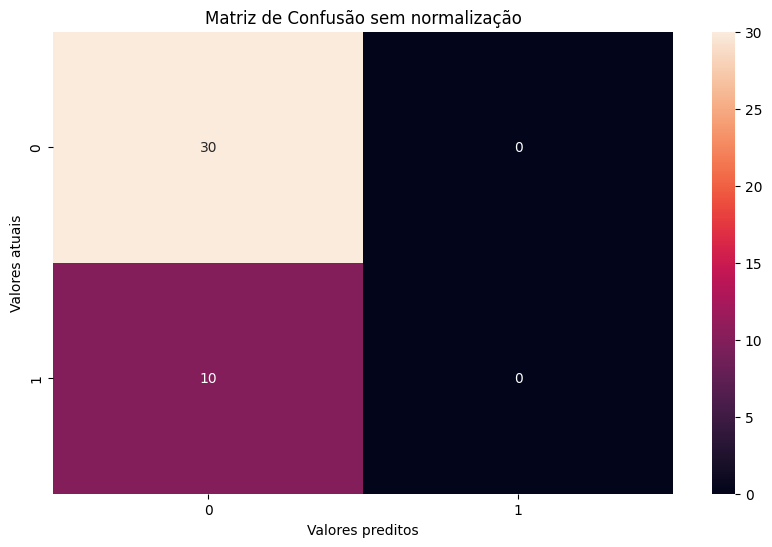

In [476]:
matriz_confusao = confusion_matrix(y_test, predicted_classes)

# criacao de dataframe para a matriz de confusão formatada em array (facilita plotagem)

matriz_confusao_df = pd.DataFrame(matriz_confusao,
                     index = ['0','1' ],
                     columns = ['0','1'])

plt.figure(figsize=(10,6))
sns.heatmap(matriz_confusao_df, annot=True,fmt="d")
plt.title('Matriz de Confusão sem normalização')
plt.ylabel('Valores atuais')
plt.xlabel('Valores preditos')
plt.show()

Como é possível ver pela matriz de confusão binária, e pelos gráficos de loss e acurácia, o modelo conseguiu apreender bem e fazer uma boa generalização, entretanto, a sua precisão só é alto para classe 0 (NÃO é cisto) - o tamanho do conjunto de dados pode ter influenciado nesse resultado. Outra questão a ser pontuada é que a curva de acurácia de validação foi constante, o que pode sugerir um overfitting, corroborando para a alta acurácia na classificação de non-CYST.